My first machine learning algorithm built in SageMaker is going to be an XGBoost algorithm running on the MNIST data set of handwritten digits.

I begin by importing the MNIST data set.

In [4]:
import boto3
import pickle
# download preprocessed data from S3
s3 = boto3.client('s3')
bucket = 'sagemaker-sample-files'
s3.download_file(bucket, 'datasets/image/MNIST/mnist.pkl', './mnist.pkl')
with open('mnist.pkl', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f)

The last few lines of code in particular will unzip the file and save the training, validation, and test data sets as `train_set`, `valid_set`, and `test_set` respectively. Typically, we'd want to also clean the data set, but the MNIST data set is pre-pruned, so this won't be necessary.

The following code chunk displays the first 10 images in `train_set`:

This is a 5


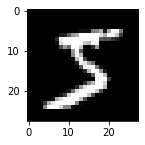

This is a 0


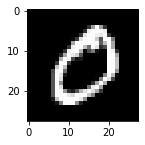

This is a 4


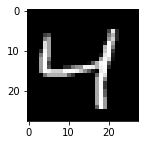

This is a 1


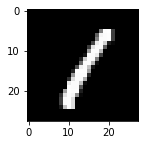

This is a 9


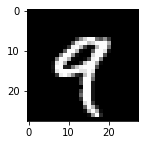

This is a 2


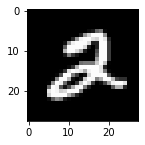

This is a 1


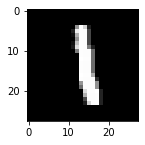

This is a 3


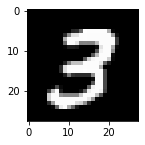

This is a 1


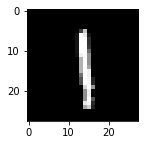

This is a 4


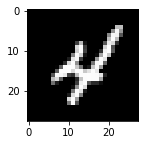

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

With the help of `matplotlib`, we can display both `train_set[0]`, which is the set of images themselves stored as pixel arrays, and `train_set[1]`, which is the set of labels.

Though we don't need to clean the data, we do need to transform it as XGBoost expects the data to be in CSV format (there are other formats XGBoost accepts, but CSV is the most convenient). However, right now, the data is formatted as `numpy.array`. The following code chunk does the necessary conversion and uploads it to the default Amazon S3 bucket associated with my account.

In [6]:
%%time

import os
import re
import copy
import time
import io
import struct
import numpy as np
from time import gmtime, strftime
import boto3
import sagemaker

role = sagemaker.get_execution_role()

region = boto3.Session().region_name

bucket = sagemaker.Session().default_bucket()   # Default S3 URI. Replace it with your S3 URI if you want.
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data

def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.flatten().tolist() for t in data_partition[0]]
        
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        
        np.savetxt('data.csv', examples, delimiter=',')
        
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
        
convert_data()

train: (60000, 1, 28, 28) (60000,)
Done writing to s3://sagemaker-us-east-2-353118680741/sagemaker/xgboost-mnist/train/examples
validation: (5000, 1, 28, 28) (5000,)
Done writing to s3://sagemaker-us-east-2-353118680741/sagemaker/xgboost-mnist/validation/examples
test: (5000, 1, 28, 28) (5000,)
Done writing to s3://sagemaker-us-east-2-353118680741/sagemaker/xgboost-mnist/test/examples
CPU times: user 1min 3s, sys: 5.93 s, total: 1min 9s
Wall time: 1min 23s


Now, I'm going to train the actual XGBoost model that we will use for this demonstration. Typically, I'd have to narrow my model choice down from a series of potential models that are all evaluated for their performance, but here, we're going to skip that step and go straight to using XGBoost. SageMaker gives the option of either using the Amazon SageMaker Python SDK or the AWS SDK for Python (Boto3). The former is easier to use and better suited for first-time users such as myself, so I'm going to use that one. First, we will make sure we are using a version of SageMaker that is at least version 2.15.2:

In [7]:
sagemaker.__version__

'2.19.0'

Then, we will import the SageMaker Python SDK and grab the XGBoost container.

In [8]:
import sagemaker

from sagemaker import image_uris

container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")

Here, we are defining the paths at which our data is stored in our S3 bucket.

In [9]:
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
print(train_data)

s3://sagemaker-us-east-2-353118680741/sagemaker/xgboost-mnist/train


Next, define an instance of the `sagemaker.estimator.Estimator` class:

In [10]:
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         instance_count=1, 
                                         instance_type='ml.m4.xlarge',
                                         volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

We can glean some important information from this block. For once, `instance_count = 1` tells us that we are only performing one training pass/instance. The instance type being `ml.m4.xlarge` is one of the more advanced compute instances offered by Amazon SageMaker. The parameter `volume_size = 5` tells us that up to 5 GB of storage volume is attached to this training instance. Finally, from `output_path`, we are telling SageMaker to store our training results in the Amazon S3 bucket output location from earlier.

Now, the fun begins. Let's first set the hyperparameters for the XGBoost model:

In [11]:
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)

Note the parameter `objective = "multi:softmax"`. Because there are more than two classes, we want to run multiclass classification, and in particular, we're using the softmax objective. This requires us to set `num_class = 10`, which is 10 because there are 10 digits to which our inputs can be classified.

Now, we assign the training and validation data to the proper `train` and `validation` channels.

In [12]:
from sagemaker.inputs import TrainingInput

train_channel = TrainingInput(train_data, content_type='text/csv')
valid_channel = TrainingInput(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

Finally, we can begin actually training the model! This is done by calling the `fit` method for the estimator. Conveniently, we can turn on `logs=True` to display progress logs. Be patient here; it could take several minutes!

In [13]:
xgb_model.fit(inputs=data_channels,  logs=True)

2021-01-22 07:51:08 Starting - Starting the training job...
2021-01-22 07:51:10 Starting - Launching requested ML instancesProfilerReport-1611301868: InProgress
......
2021-01-22 07:52:23 Starting - Preparing the instances for training......
2021-01-22 07:53:24 Downloading - Downloading input data...
2021-01-22 07:54:09 Training - Downloading the training image...
2021-01-22 07:54:30 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimite

For reference, it took me about ten total minutes of runtime to fit the model, with six of those minutes (384 seconds, to be precise) spent actually training the model. For you, it could take up to 15 minutes depending on your computer specs.

Now, it's time to actually deploy the model and generate some predictions. This can be done one at a time in realtime using SageMaker hosting services or it can be done on an entire data set using a batch transform. Let's start with realtime single predictions using SageMaker hosting services. This can once again be done in the SageMaker Python SDK or using the AWS SDK (Boto3). We'll continue to use the SageMaker Python SDK because it's still easier to use. In fact, it's easy enough in the SageMaker Python SDK that it can basically be done with a singular function call.

In [22]:
from sagemaker.serializers import CSVSerializer

xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium',
                                 serializer=CSVSerializer()
                                )

---------------------!

(It should be noted, by the way, that there appears to be a mistake in the tutorial here. The code block from the tutorial specifies a `content_type='text/csv'` argument, but as of SageMaker Python SDK 2.0, this appears to be deprecated and is no longer necessary. Instead, it seems to specify the use of something called a "serializer class", so I added the `CSVSerializer` import line above and the `serializer = CSVSerializer()` argument, which seems to be the new way to specify content type now. Also, this step too can take quite a long time as well, so be patient.)

If we wanted inference on an entire data set using batch transform (in SageMaker Python SDK) instead, that would look like this:

In [16]:
# The location of the test dataset
batch_input = 's3://{}/{}/test/examples'.format(bucket, prefix)

# The location to store the results of the batch transform job
batch_output = 's3://{}/{}/batch-inference'.format(bucket, prefix)

transformer = xgb_model.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

transformer.wait()

................................2021-01-22T08:33:10.269:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD

[2021-01-22:08:33:08:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-22:08:33:08:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-22:08:33:08:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

[2021-01-22:08:33:08:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-22:08:33:08:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-22:08:33:08:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }


This too can take a significant amount of time, so be prepared to wait here as well.

Now that we've both trained and deployed our models, it's time to validate them, which basically amounts to checking to see if they're actually decent by generating accurate predictions on new data. This is where the test data comes in handy. We're going to make use of this, as well as the `RealTimePredictor` object created in the hosting services model and the transformed model from the `transform` call as well.

We start by downloading the test data from Amazon S3.

In [17]:
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

To be sure we're on the right track here, let's take a look at images of some of our test digits.

This is a 3


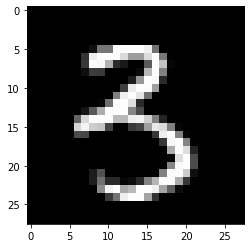

This is a 9


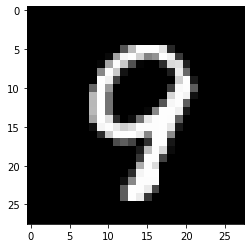

This is a 9


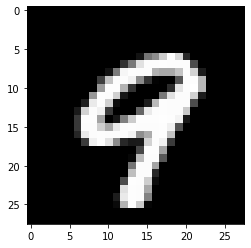

This is a 8


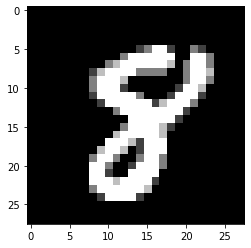

This is a 4


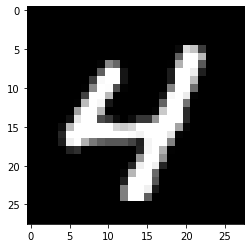

This is a 1


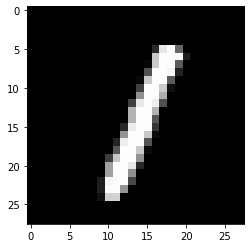

This is a 0


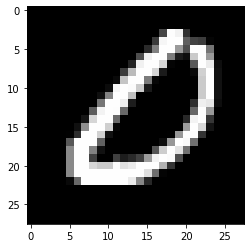

This is a 6


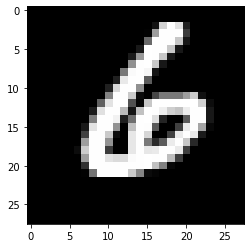

This is a 0


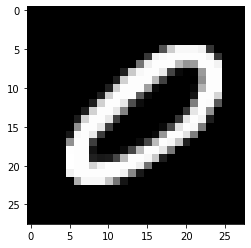

This is a 9


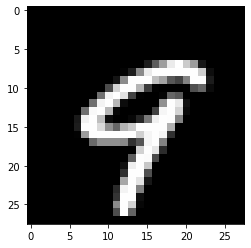

In [18]:
%matplotlib inline
                        
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

Using a `for` loop, we can get a prediction on these ten digits using the following code chunk:

In [23]:
with open('test_data', 'r') as f:
    for j in range(0,10):
        single_test = f.readline()
        result = xgb_predictor.predict(single_test)
        print(result)

b'3.0'
b'9.0'
b'9.0'
b'8.0'
b'4.0'
b'1.0'
b'0.0'
b'6.0'
b'0.0'
b'4.0'


From the above output, we can see that the model made nine out of ten correct predictions (final digit is a 9, not a 4), which is not bad!

We can assess the batch-transformed model by downloading the output of the batch transform job from Amazon S3 to a local file and then polling the first ten results from it.

In [24]:
# downloading output of batch transform to local file
s3.Bucket(bucket).download_file(prefix + '/batch-inference/examples.out',  'batch_results')

# reading in first 10 results
with open('batch_results') as f:
    results = f.readlines()
for j in range (0, 10):
    print(results[j])

3.0

9.0

9.0

8.0

4.0

1.0

0.0

6.0

0.0

4.0



As anticipated, the output (and thus, model accuracy) is the same. We are done!